In [1]:
import os
import random
import multiprocessing as mp

import numpy as np
import pandas as pd
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from IPython.display import clear_output


# Setting global variables
# Model
MODEL_DIR = "./saved_models"
DATASET_PREFIX = "./data/MNIST"
DATA_PATH = f"{DATASET_PREFIX}/raw/mnist_dataset.csv"
CHECKPOINT_FREQ = 5
NUM_CLASSES = 10


# Devices
N_CPUS = mp.cpu_count()
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Fixing seeds so all stochastic events are actually deterministic
SEED = 0
DL_GENERATOR = torch.Generator()
DL_GENERATOR.manual_seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic=True


def seed_worker(worker_id):
    worker_seed = SEED + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [2]:
# Subclassing Pytorch's Dataset class. Dataset is an abstract class, which means it defines a specification 
# of what its subclasses must look like via function signatures. However, these functions are not actually implemented in 
# the source code of the Dataset class. It's the programmer's job (yours!) to make sure the methods laid out in the  
# signatures are implemented


# Here we define our dataset - it is a map-style dataset, which means we have to know its size at initialisation and  
# must be able to access data points at arbitrary locations. This is why the following methods must be implemented:
# __len__ and __getitem__ 
class MNISTDataset(Dataset):
    def __init__(self, filepath: str): 
        super().__init__()
        self.dataframe = pd.read_csv(filepath) # Load data from CSV filepath defined earlier into a Pandas dataframe
    
    def __len__(self):
        return len(self.dataframe) # Return size of our dataframe
        
    def __getitem__(self, i):
        return self.dataframe.iloc[i] # Return the `i`th item in our dataframe

In [9]:
from PIL import Image



def custom_collate_fn(batch):
    # The collate function is used to tell the Pytorch DataLoader how to handle datapoints from the MNISTDataset we 
    # defined earlier and pack them into a batch. By default (i.e. no specific collate_fn is passed), the DataLoader
    # would simply add the dataset items to an array and ensure that the array is of a certain size (the batch size).
    # This would normally not be a problem if we were working with text data that is of a fixed length. However, 
    # in our case, we are working with image data, and our dataset (so far) does not actually contain the images 
    # themselves, but filepaths to them, along with labels. For this reason, we must define a custom collate function
    # that reads these images and their labels into memory, and returns them side-by-side so we can use them in our 
    # neural network.
    def load_image_tensor(filepath):
        # This funtion is only visible inside custom_collate_fn and does the work of loading a single image into
        # a Pytorch Tensor
        img = Image.open(filepath)
        transform = transforms.Compose([
            transforms.PILToTensor()
        ])
        img_tensor = transform(img)
        return img_tensor

    image_batch_tensor = torch.FloatTensor(len(batch), 28, 28) # We define a tensor of the same size as our image batch to store loaded images into
    image_tensors = []
    labels = []
    for item in batch:
        image_tensor = load_image_tensor(f"{DATASET_PREFIX}/{item[0]}") # load a single image
        image_tensors.append(image_tensor) # put image into a list 
        labels.append(item[1]) # put the same image's label into another list
                                         
                                         
    torch.cat(image_tensors, out=image_batch_tensor) # torch.cat simply concatenates a list of individual tensors (image_tensors) into a single Pytorch tensor (image_batch_tensor)
    label_batch_tensor = torch.FloatTensor(labels).type(torch.int64) # use the label list to create a torch tensor of ints
    return (image_batch_tensor, label_batch_tensor)



def load_data(batch_sz=100, train_val_test_split=[0.8, 0.1, 0.1]):
    # This is a convenience funtion that returns dataset splits of train, val and test according to the fractions specified in the arguments
    assert sum(train_val_test_split) == 1, "Train, val and test fractions should sum to 1!"  # Always a good idea to use static asserts when processing arguments that are passed in by a user!
    train_dataset = MNISTDataset(DATA_PATH)  # Instantiating our previously defined dataset
    
    # This code generates the actual number of items that goes into each split using the user-supplied fractions
    train_val_split = list(
        map( # map applies a given function to each element of a list
            lambda frac: round(frac * len(train_dataset)), # anonymous function that multiplies the fraction by total length of dataset and rounds to the nearest integer
            train_val_test_split # the list to apply the function to
        )
    )
    
    # split dataset into train, val and test
    train_split, val_split, test_split = random_split(train_dataset, train_val_split, generator=DL_GENERATOR)
    
    # Use Pytorch DataLoader to load each split into memory. It's important to pass in our custom collate function, so it knows how to interpret the 
    # data and load it. num_workers tells the DataLoader how many CPU threads to use so that data can be loaded in parallel, which is faster
    train_dl = DataLoader(train_split, 
                          batch_size=batch_sz, 
                          shuffle=True, 
                          collate_fn=custom_collate_fn,
                          worker_init_fn=seed_worker,
                          num_workers=N_CPUS,
                          generator=DL_GENERATOR)
    val_dl = DataLoader(val_split, 
                        batch_size=batch_sz, 
                        shuffle=True, 
                        collate_fn=custom_collate_fn,
                        num_workers=N_CPUS,
                        worker_init_fn=seed_worker,
                        generator=DL_GENERATOR)
    test_dl = DataLoader(test_split,
                         batch_size=batch_sz,
                         shuffle=False,
                         collate_fn=custom_collate_fn,
                         num_workers=N_CPUS,
                         worker_init_fn=seed_worker,
                         generator=DL_GENERATOR)
    return train_dl, val_dl, test_dl

In [14]:
import matplotlib.pyplot as plt

# Visualisation helper functions. When working with image data, it can be helpful to define such functions to
# make sure that the data visually "looks right". It is also a pretty good indication that you probably got all
# the dataloading code correct!

def image_grid(batch, ncols=4):
    height, width = batch[0].shape
    nrows = len(batch)//ncols # calculate the number of rows based on the number of columns needed by the user
    
    img_grid = (batch.reshape(nrows, ncols, height, width)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols))
    
    return img_grid


def show_batch(batch, title="Image batch", cols=4):
    N = len(batch)
    if N > cols:
        assert N % cols == 0, "Number of cols must be a multiple of N"
    
    result = image_grid(batch)
    fig = plt.figure(figsize=(5., 5.))
    plt.suptitle(f"{title} [{int(N/cols)}x{cols}]")
    plt.imshow(result)

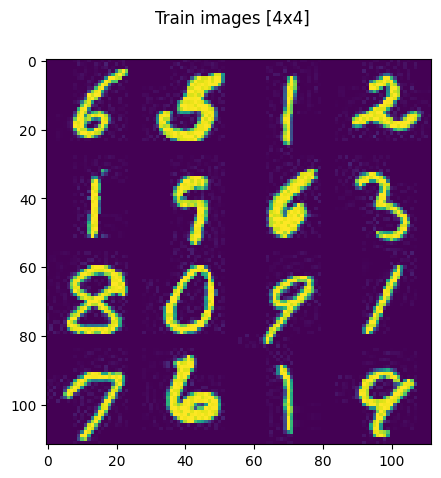

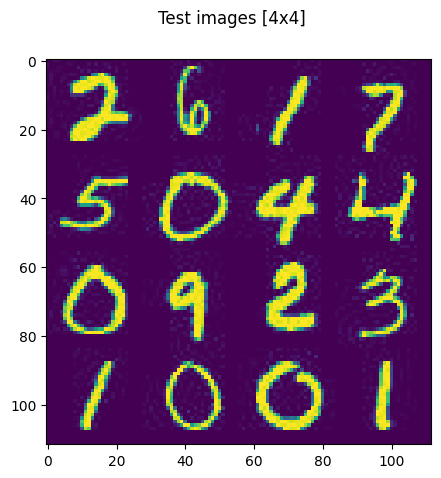

In [15]:
train_dl, val_dl, test_dl = load_data(batch_sz=16)

train_images, _ = next(iter(train_dl))
test_images, _ = next(iter(test_dl))

show_batch(train_images, title="Train images", cols=4)
show_batch(test_images, title="Test images", cols=4)

In [ ]:
import torch.nn as nn 

# Defining models





simple_seq_net = nn.Sequential(
    nn.Conv2d(
        
        in_channels=1,              
        out_channels=16,            
        kernel_size=5,              
        stride=1,                   
        padding=2,                  
    ),                              
    nn.ReLU(),                      
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(16, 32, 5, 1, 2),     
    nn.ReLU(),                      
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(32 * 7 * 7, NUM_CLASSES)
)




In [ ]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample):
        super().__init__()
        if downsample:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            self.shortcut = nn.Sequential()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, inp):
        shortcut = self.shortcut(inp)
        inp = nn.ReLU()(self.bn1(self.conv1(inp)))
        inp = nn.ReLU()(self.bn2(self.conv2(inp)))
        inp = inp + shortcut
        return nn.ReLU()(inp)
    


class ResNet(nn.Module):
    def __init__(self, in_channels, resblock, outputs):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.layer1 = nn.Sequential(
            resblock(64, 64, downsample=False),
            resblock(64, 64, downsample=False)
        )

        self.layer2 = nn.Sequential(
            resblock(64, 128, downsample=True),
            resblock(128, 128, downsample=False)
        )

        self.layer3 = nn.Sequential(
            resblock(128, 256, downsample=True),
            resblock(256, 256, downsample=False)
        )


        self.layer4 = nn.Sequential(
            resblock(256, 512, downsample=True),
            resblock(512, 512, downsample=False)
        )

        self.gap = nn.AdaptiveAvgPool2d(1)
        self.flat = nn.Flatten() 
        self.fc = nn.Linear(512, outputs)

    def forward(self, inp):
        inp = self.layer0(inp)
        inp = self.layer1(inp)
        inp = self.layer2(inp)
        inp = self.layer3(inp)
        inp = self.layer4(inp)
        inp = self.gap(inp)
        inp = self.flat(inp)
        inp = self.fc(inp)

        return inp
    

In [ ]:
import torch.optim as topt
from torch.optim.lr_scheduler import ExponentialLR


# Adaptive learning rate. From the lectures, you may remember 
# that the learning rate of an optimiser is a measure of how far the weights 
# are allowed to 'step' in the direction of the gradient. So far, the LR has been constant (and large) which means that
# the model takes large steps towards the optimal solution. This might not be ideal however - as the weights of the
# model start to converge on the optimal solution, the large steps taken by the optimiser
# may over/undershoot it. Therefore, we want a relatively large LR early on in the training (to quickly get close to
# the neighbourhood of the optimal solution) and decrease LR as we get closer to the solution (so that we don't
# over/undershoot it). In Pytorch, this is handled by a class called the learning rate scheduler 
toy_model = nn.Linear(2, 1)
optimizer = topt.SGD(toy_model.parameters(), lr=1)
schd = ExponentialLR(optimizer, gamma=0.3)

lrs = []
for i in range(15):
    optimizer.zero_grad()
    optimizer.step()
    lrs.append(schd.get_last_lr())
    schd.step()

plt.plot(lrs)

In [ ]:
# Model training on a typical machine learning project is a time-consuming process. Sometimes, we may even want to 
# run models multiple times with different parameters to see which ones work the best (a process known as hyper-
# parameter tuning). If a model is allowed to run for a long time despite not getting any better at learning,
# that's wasted time and computing power. We use early stopping to tackle this problem. This is a simple algorithm 
# that just 
class EarlyStopper:
    def __init__(self, patience=1, tolerance=0):
        self.patience = patience
        self.tolerance = tolerance
        self.counter = 0
        self.max_validation_acc = np.NINF

    def should_stop(self, validation_acc):
        if validation_acc > self.max_validation_acc:
            self.max_validation_acc = validation_acc
            self.counter = 0
        elif validation_acc < (self.max_validation_acc - self.tolerance):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [ ]:
from torch.utils.tensorboard import SummaryWriter


def save_model(model, epoch, save_dir):
    filename = f"checkpoint_{epoch}.pth"
    save_path = os.path.join(save_dir, filename)
    torch.save(model, save_path)

    
# Need to work in Early stopping (https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch) and Learning Rate scheduling (https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)
def train_model(model, epochs, dataloaders, optimiser, scheduler, checkpoint_frequency=5):
    writer = SummaryWriter()
    early_stopper = EarlyStopper(patience=3, tolerance=0.05)
    msg = "" # just some code for fancy printing, never mind this :)
    for epoch in range(epochs):
        for phase in ['train', 'val']:
            if phase == "train":
                model.train()
            else:
                model.eval()
            total_steps = len(dataloaders[phase])

            correct = 0
            total = 0
            
            for batch_num, (image_batch, label_batch) in enumerate(dataloaders[phase]):
                optimiser.zero_grad()
                batch_sz = len(image_batch)
                label_batch = label_batch.to(DEVICE)
                image_batch = image_batch.to(DEVICE).reshape(batch_sz, 1, 28, 28)    

                output = model(image_batch)
                losses = loss_fn(output, label_batch)

                if phase == "train":
                    losses.backward()
                    optimiser.step()
                    


                preds = torch.argmax(output, dim=1)
                correct += int(torch.eq(preds, label_batch).sum())
                total += label_batch.shape[0]
                writer.add_scalar(f'Loss/{phase}', losses.item(), (epoch*epochs) + batch_num)
                if (batch_num + 1) % 5 == 0:
                    print(" " * len(msg), end='\r')
                    msg = f'Epoch[{epoch+1}/{epochs}], Step[{batch_num + 1}/{total_steps}], Loss({phase}): {losses.item():.4f}, Acc({phase}): {correct/total:.5f}, LR: {scheduler.get_last_lr()[0]:.3f}'
                    if early_stopper.counter > 0:
                        msg += f", Epochs without improvement: {early_stopper.counter}"
                    print (msg, end='\r' if epoch < epochs else "\n",flush=True)
            accuracy = 100 * correct / total
            
            if phase == "val" and early_stopper.should_stop(accuracy):
                print(f"\nValidation accuracy has not improved for {early_stopper.counter} epochs, stopping training early at epoch {epoch + 1}")
                return
        
            writer.add_scalar(f'Acc/{phase}', accuracy, epoch)
            if phase == "val":
                if (epoch + 1) % checkpoint_frequency == 0:
                    save_model(model, epoch + 1, "./saved_models")
            
            
            scheduler.step()
            
                    

def test_model(model, dataloaders):
    writer = SummaryWriter()
    model.eval()
    correct = 0
    total = 0
    total_steps = len(dataloaders['test'])
    msg = ""
    for batch_num, (image_batch, label_batch) in enumerate(dataloaders['test']):
        batch_sz = len(image_batch)
        label_batch = label_batch.to(DEVICE)
        image_batch = image_batch.to(DEVICE).reshape(batch_sz, 1, 28, 28)
        out = model(image_batch)
        preds = torch.argmax(out, dim=1)
        correct += int(torch.eq(preds, label_batch).sum())
        total += label_batch.shape[0]
        if (batch_num + 1) % 5 == 0:
            print(" " * len(msg), end='\r')
            msg = f'Testing batch[{batch_num + 1}/{total_steps}]'
            print (msg, end='\r' if batch_num < total_steps else "\n", flush=True)
    print(f"Final test accuracy for {total} examples: {correct/total:.3f}")
        


In [ ]:
epochs = 20
train_batch_sz = val_batch_sz = 128


# This is actually a very high initial learning rate and is only intended to 
# exaggerate the difference an adaptive LR scheduler makes. Real 
# applications initialise their LRs to something many orders of magnitude smaller
learning_rate = 1  

train_dl, val_dl, test_dl = load_data(batch_sz=train_batch_sz)
dataloaders = {'train': train_dl, 'val': val_dl, 'test': test_dl}




network = ResNet(1, ResBlock, outputs=NUM_CLASSES)
# network = simple_seq_net
loss_fn = nn.CrossEntropyLoss()
optim = topt.SGD(network.parameters(), lr=learning_rate)
scheduler = ExponentialLR(optim, gamma=0.8)
network = network.to(DEVICE)


train_model(network, epochs, dataloaders, optim, scheduler)

# Notice how due to the very high initial learning rate, the accuracy shoots up from ~0.7 to ~0.9 between epochs 1 and 2
# Subsequent imporovements are much slower due to the exponential decay of the LR

In [ ]:
loaded_net = torch.load("./saved_models/checkpoint_15.pth")
test_model(loaded_net, dataloaders)